In [20]:
import os
import shutil
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from official.nlp import optimization  # to create AdamW optimizer

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
tf.get_logger().setLevel('ERROR')

In [2]:
main_data=pd.read_csv("sarcasm_v2\\GEN-sarc-notsarc.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
classes = {"notsarc" : 0,"sarc" : 1}
data["class"] = data["class"].map(classes)
data

,class,text
0,0,"If that's true, then Freedom of Speech is doom..."
1,0,Neener neener - is it time to go in from the p...
2,0,"Just like the plastic gun fear, the armour pie..."
3,0,So geology is a religion because we weren't he...
4,0,Well done Monty. Mark that up as your first ev...
...,...,...
6515,1,depends on when the baby bird died. run alon...
6516,1,"ok, sheesh, to clarify, women who arent aborti..."
6517,1,so.. eh?? hows this sound? will it fly w...
6518,1,"I think we should put to a vote, the right of ..."


In [3]:
ps = PorterStemmer()

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext

In [6]:
data['text'][64]

'There are several scientific explanations for the nature of the earth. Some use \'science\' to say that the world is flat. Granted that these beliefs aren\'t widely accepted, but then not all religions are widely accepted. By your reasoning or \'logic\' you must ask yourself about whether you should rely on science when there are many different scientific theories.The Flat Earth News, at least back then, had a regular column, "One Hundred Proofs Earth is Not a Globe."(go to http://www.flat-earth.org/)Other theories taught as sciencephrenologyalchemyevolutioneugenicsneptunismTheories of the Aether Articles relating to the Emergence of Scientific Theories of the Cosmic Aether(http://www.mountainman.com.au/aether.html)What about \'metascience\'?http://www.calresco.org/lucas/science.htmOr, sciences used to support political ends...What about Marxist Sciencehttp://www.marxists.org/archive/hald...philosophy.htmor Chaos Theory and Marxismhttp://www.marxist.com/science/chaostheory.htmlThere\'

In [7]:
clean_text(data['text'][64])

'sever scientif explan natur earth use scienc say world flat grant belief wide accept religion wide accept reason logic must ask whether reli scienc mani differ scientif theori flat earth news least back regular column one hundr proof earth globe go theori taught sciencephrenologyalchemyevolutioneugenicsneptunismtheori aether articl relat emerg scientif theori cosmic aether metasci scienc use support polit end marxist scienc chao theori marxism nazi scienc scienc social end scientif racism scientist instead use word heret use word pseudo scienc categoris fring belief'

In [8]:
#preprocess train dataset
data['text'] = data['text'].apply(clean_text)

In [10]:
### Vocabulary size
voc_size=50000
onehot_repr=[one_hot(words,voc_size)for words in data['text']] 
onehot_repr

[[19766, 5581, 41079, 41232, 18964, 1155, 37466, 16462, 38729, 18964, 28332],
 [43030, 43030, 29666, 4436, 441, 3718],
 [38729,
  31009,
  37790,
  7735,
  14773,
  3809,
  6277,
  7735,
  3296,
  47484,
  36458,
  35490],
 [7530, 1924, 43486, 44053, 48956, 3283],
 [47111, 17944, 31683, 18246, 31239, 3376, 45661, 12862, 34090, 13350],
 [1267,
  46546,
  17944,
  10967,
  27384,
  46546,
  9584,
  46145,
  19947,
  16826,
  43496,
  4982,
  10967,
  31341,
  24898,
  10967,
  14556,
  17655,
  45900,
  35429,
  9993],
 [46697, 47340, 29613, 32339, 39586],
 [2621,
  41699,
  18375,
  43446,
  30993,
  217,
  7679,
  49597,
  6890,
  29108,
  49597,
  41137,
  21203,
  3526,
  35599,
  5552,
  34106,
  12052,
  23041],
 [22001,
  5904,
  45612,
  21587,
  42631,
  5130,
  11405,
  44725,
  1452,
  11884,
  40025,
  17983,
  41282,
  5130,
  11405,
  10237,
  25002,
  13570,
  16768,
  17312,
  13570,
  46697,
  35838,
  36857,
  16646,
  49931,
  2757,
  46697,
  10616,
  32222,
  24519,


In [11]:
sent_length=150
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ... 38729 18964 28332]
 [    0     0     0 ...  4436   441  3718]
 [    0     0     0 ... 47484 36458 35490]
 ...
 [    0     0     0 ... 11125 22300 41585]
 [    0     0     0 ... 17944 43548 11718]
 [    0     0     0 ... 17817  9389 45185]]


In [12]:
y=data['class']

In [13]:
len(embedded_docs),y.shape

(6520, (6520,))

In [14]:
X=np.array(embedded_docs)
y=np.array(y)

In [15]:
X.shape, y.shape

((6520, 150), (6520,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print(y_train)

[0 1 1 ... 0 0 0]


In [18]:
print('===========Train Data =========')
print("1:    ",sum(y_train),"\n0:    ",(y_train.shape[0]-sum(y_train)))
print("Total:",len(X_train))
print('===============================')

print('===========Test Data =========')
print("1:    ",sum(y_test),"\n0:    ",(y_test.shape[0]-sum(y_test)))
print("Total:",len(X_test))
print('===============================')


===========Train Data =========
1:     2616 
0:     2600
Total: 5216
===========Test Data =========
1:     644 
0:     660
Total: 1304


In [21]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 40)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 2,113,001
Trainable params: 2,113,001
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.fit(X_train,y_train,validation_split=0.2,epochs=7,batch_size=64)

Epoch 1/7
66/66 [==============================] - 30s 357ms/step - loss: 0.6649 - accuracy: 0.5896 - val_loss: 0.6268 - val_accuracy: 0.6542
Epoch 2/7
66/66 [==============================] - 25s 384ms/step - loss: 0.5339 - accuracy: 0.7447 - val_loss: 0.5911 - val_accuracy: 0.6801
Epoch 3/7
66/66 [==============================] - 30s 453ms/step - loss: 0.3862 - accuracy: 0.8368 - val_loss: 0.5795 - val_accuracy: 0.7232
Epoch 4/7
66/66 [==============================] - 29s 433ms/step - loss: 0.2485 - accuracy: 0.9063 - val_loss: 0.6506 - val_accuracy: 0.6954
Epoch 5/7
66/66 [==============================] - 26s 400ms/step - loss: 0.1755 - accuracy: 0.9367 - val_loss: 0.8063 - val_accuracy: 0.7050
Epoch 6/7
66/66 [==============================] - 26s 400ms/step - loss: 0.1233 - accuracy: 0.9573 - val_loss: 0.8289 - val_accuracy: 0.6849
Epoch 7/7
66/66 [==============================] - 26s 389ms/step - loss: 0.0974 - accuracy: 0.9674 - val_loss: 0.9288 - val_accuracy: 0.6954


In [23]:
model.evaluate(X_test,y_test)

41/41 [==============================] - 2s 53ms/step - loss: 0.9363 - accuracy: 0.6863


[0.9362643957138062, 0.6863496899604797]

In [24]:
y_pred=model.predict(X_test)

In [25]:
y_pred

array([[0.11645836],
       [0.1328961 ],
       [0.98170733],
       ...,
       [0.9900988 ],
       [0.76043326],
       [0.7412878 ]], dtype=float32)

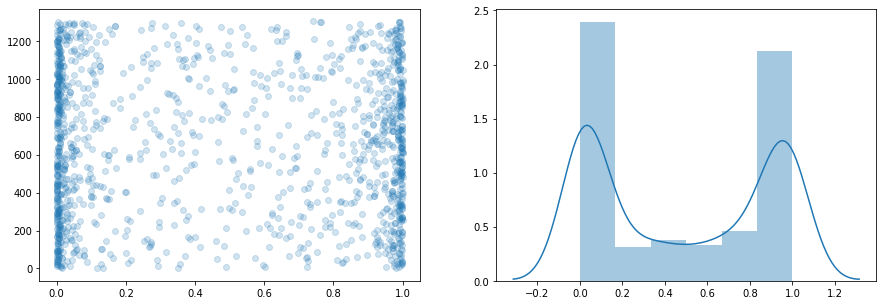

In [26]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(y_pred,range(0,y_pred.shape[0]),alpha=0.2)
ax2=sns.distplot(y_pred)

In [27]:
cutoff=0.6

y_pred = np.where((y_pred >= cutoff),1,y_pred)
y_pred = np.where((y_pred < cutoff),0,y_pred)

labels = [0, 1]
print(classification_report(y_test.tolist(),y_pred.tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       660
           1       0.70      0.65      0.67       644

    accuracy                           0.69      1304
   macro avg       0.69      0.69      0.69      1304
weighted avg       0.69      0.69      0.69      1304



In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[481, 179],
       [226, 418]], dtype=int64)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6894171779141104